In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import math

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

## 0 Load Data

In [3]:
raw_data = pd.read_csv("fingerprint_data.csv",  dtype={'imsi':np.str})

In [4]:
raw_data.shape

(11094, 72)

In [5]:
raw_data.columns

Index(['user_id', 'idfa', 'imei', 'mac', 'imsi', 'android_id', 'phone_model',
       'phone_name', 'networktype', 'version', 'lcd', 'phone_os', 'battery',
       'totalmemory', 'availablememory', 'totalsystem', 'availablesystem',
       'totalsd', 'availablesd', 'udid', 'basestation', 'rssi', 'mnc', 'mcc',
       'cellid', 'lac', 'nearbybasestation', 'displayrom', 'currentwifi',
       'simulator', 'product', 'hardware', 'stat', 'sdkversion', 'brightness',
       'cpuspeed', 'simstate', 'fingerprint', 'hascellular', 'haswifi',
       'hasgps', 'hastelephony', 'hasbluetooth', 'simserial',
       'gravitysensorlist', 'grav_x', 'grav_y', 'grav_z', 'simlac',
       'simstrength', 'gyroscopesensorlist', 'x', 'y', 'z',
       'pressuresensorlist', 'type', 'tags', 'networkoperator', 'manufacturer',
       'device', 'currenttime', 'cpuabi', 'cellularip', 'networkcountryiso',
       'simcountryiso', 'bluetooth', 'host', 'cpuarchitecture',
       'imanufacturer', 'timestamp', 'ethip', 'trueip'],

## 1 MD5 Hash

In [6]:
import hashlib

def md5_hash(df, feature_columns):
    df['concat'] = df[feature_columns].iloc[:, :].astype(str).add('_').sum(axis=1)
    
    df['md5'] = [hashlib.md5(val.encode("UTF8")).hexdigest() for val in df['concat']]
    
    return df

In [7]:
#test_df = md5_hash(raw_data.copy(), [ 'phone_model', 'phone_name'])
#test_df['concat']

## 2.1 Information Gain

In [8]:
def entropy(df, label_column):
    p_data= df[label_column].value_counts()/len(df) # calculates the probabilities
    entropy=stats.entropy(p_data) # input probabilities to get the entropy
    return entropy

In [9]:
DEBUG = False

def relative_entropy(df, label_column, feature_column):
    if(DEBUG):
        print(feature_column)
    if label_column == feature_column:
        return 0
    
    df_tmp = df[[label_column, feature_column]]
    ## [feature, label, sub_count]
    df_feature_label = df_tmp.groupby([feature_column, label_column]).size().reset_index(name='sub_count')
    ## [feature, count]
    df_feature = df_tmp.groupby(feature_column).size().reset_index(name='count')

    ## [feature, label, sub_count, count]
    df_group = df_feature_label.merge(df_feature, on = feature_column)
    
    ## [feature, label, sub_count, count]
    ## TODO apply is slow
    df_group['group_entropy'] =  df_group.apply(lambda x: math.log(x['count'] / x['sub_count']) * x['sub_count'] / x['count'], axis=1) 
    
    ## [feature, group_entropy]
    group_entropy = df_group.groupby(feature_column)['group_entropy'].sum().reset_index(name='group_entropy')
    
    ## [feature, count, ratio]
    df_feature['ratio'] = df_feature['count']/ df.shape[0]
    relative_env = (group_entropy['group_entropy'] * df_feature['ratio']).sum()
    
    return relative_env 

In [10]:
def information_gain(df, label_column, feature_columns):
    ent = entropy(df, label_column)
    ent_map = [ relative_entropy(df, label_column, column) for column in feature_columns]
    ig = ent - ent_map 
    ig_map = dict(zip(feature_columns, ig))
    return ig_map

*  https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

## 2.2 Stability

In [11]:
def stability_calc(df, label_column, feature_column):
    if(DEBUG):
        print(feature_column)
    if label_column == feature_column:
        return 1
    
    df_tmp = df[[label_column, feature_column]]
    
     # [label, count], filter label by count
    df_label_cnt = df_tmp.groupby(label_column).size().reset_index(name='count')
    # at least appear twice, then consider stability
    df_label = df_label_cnt[df_label_cnt['count'] > 1]
           
    # [label, distinct_feature_count]
    df_label_feature_cnt = df_tmp.groupby(label_column).agg({feature_column: pd.Series.nunique}).reset_index()
    
    result = pd.merge(df_label,df_label_feature_cnt,how='inner',on=label_column)
    return result[feature_column].sum() /  result.shape[0]

In [12]:
def stability(df, label_column, feature_columns):
    stable_list = [ stability_calc(df, label_column, column) for column in feature_columns]
    
    stable_map =  dict(zip(feature_columns, stable_list))
    #return sorted(stable_map.items(), key=lambda kv: -kv[1])
    return stable_map

## 3 Evaluation

In [13]:
def evaluation(df, label_column, fp_column):
    df_label_fp = df[[label_column, fp_column]].copy()
    
    label_same = pd.merge(df_label_fp,df_label_fp,how='inner',on=label_column)
    fp_same = pd.merge(df_label_fp,df_label_fp,how='inner',on=fp_column)
    
    sample_cnt = df_label_fp.shape[0]
    fp_same_cnt = fp_same.shape[0] - sample_cnt
    label_same_cnt = label_same.shape[0] - sample_cnt
    truePositiveCnt = fp_same [fp_same.imei_x == fp_same.imei_y].shape[0] - sample_cnt
    
    recall = truePositiveCnt / label_same_cnt
    precision = truePositiveCnt / fp_same_cnt
    return {'precision':precision, 'recall':recall}

In [14]:
def fp_evaluation(df, label_column, feature_columns):   
    fp_feature_columns = np.setdiff1d(feature_columns, np.array([label_column]))
    
    md5_hash(df, feature_columns)
    ret = evaluation(df, label_column, 'md5')
    return ret

## 4 特征指标计算

In [15]:
df = raw_data.copy()
df.fillna('MISSING', inplace=True)

label_column = 'imei'
feature_columns = df.columns.difference([label_column])

In [16]:
## waiting time, a cup of coffee, several minutes

In [17]:
print("======= information gain =========")
info_gain = information_gain(df, label_column, feature_columns)

print("======= stability =========")
stable = stability(df, label_column, feature_columns)

df_features = pd.DataFrame([info_gain, stable]).transpose().rename(columns={0:'info_gain', 1:'stable'}).sort_values(by='info_gain',ascending=False)

======= information gain =========
======= stability =========


In [18]:
df_features = df_features.round(2)

In [19]:
#df_features

In [20]:
fp_features = df_features[ (df_features.info_gain > 1) &  (df_features.stable < 1.1 ) ]

In [21]:
fp_features

,info_gain,stable
imsi,9.22,1.01
simserial,9.21,1.01
mac,8.92,1.03
fingerprint,5.97,1.02
phone_model,5.36,1.00
displayrom,5.35,1.01
product,5.26,1.00
totalsystem,4.79,1.00
totalsd,4.79,1.00
cpuspeed,2.97,1.02


In [22]:
fp_features.sort_values(by=['stable'], ascending=False)

,info_gain,stable
mnc,1.95,1.09
mac,8.92,1.03
fingerprint,5.97,1.02
cpuspeed,2.97,1.02
imsi,9.22,1.01
simserial,9.21,1.01
displayrom,5.35,1.01
phone_model,5.36,1.00
product,5.26,1.00
totalsystem,4.79,1.00


In [23]:
fp_features.shape

(16, 2)

## 5  特征筛选

In [24]:
id_columns = ['imsi', 'simserial', 'mac']

normal_columns = fp_features.index.difference(id_columns).values.tolist()

### 5.1 ID类特征

In [25]:
for c in id_columns:
    print('only ' + c)
    ret = fp_evaluation(df, label_column, [c])
    print(ret)

only imsi
{'precision': 0.9986842105263158, 'recall': 0.9908616187989556}
only simserial
{'precision': 0.6837837837837838, 'recall': 0.9908616187989556}
only mac
{'precision': 0.005410082823714197, 'recall': 0.9712793733681462}


### 5.2 非ID类特征 - 过度关联

In [26]:
print('NO ID Feature ')
ret = fp_evaluation(df, label_column, normal_columns)
print(ret)

NO ID Feature 
{'precision': 0.006752437270257312, 'recall': 0.8825065274151436}


### 5.3 混合 - 过度区分

In [27]:
ret = fp_evaluation(df, label_column, fp_features.index)
print(ret)

{'precision': 1.0, 'recall': 0.8472584856396866}


### 5.4 forward selection

In [28]:
from IPython.display import display, HTML
pd.set_option('max_colwidth', 180)

def show_ret(ret_list):
    ret_df = pd.DataFrame(ret_list)
#     display(ret_df[0:10])
    
    ax = ret_df.plot(y=['recall'], xticks=ret_df.index, figsize=(10,4), grid=True)
    ax.set_xticklabels(ret_df['column'], rotation=90)
    
    return ret_df

In [29]:
candidates = fp_features.index.tolist()

In [30]:
selected_columns = []
left_columns = list(set(candidates) - set(selected_columns)) 

ret_list = []
while( len(left_columns) > 0 ):
    max_recall = 0
    cur_column = None
    cur_ret = None
    
    if(len(selected_columns) == 0):
        ## Don't calc for every single feature. When the information_gain of a feature is low, memory would be explosive for merge in evaluation
        cur_column = 'imsi'
        cur_ret = fp_evaluation(df, label_column, ['imsi'])
    else:
        ## Get Best Feature
        for c in left_columns:
            ret = fp_evaluation(df, label_column, selected_columns + [c])
            if(ret['recall'] > max_recall):
                max_recall = ret['recall']
                cur_column = c
                cur_ret = ret

    ## Append Best Feature
    selected_columns.append(cur_column)
    left_columns = list(set(candidates) - set(selected_columns)) 
    
    cur_ret['feature'] = selected_columns.copy()
    cur_ret['column'] = cur_column
    ret_list.append(cur_ret)
    if(DEBUG):
        print(cur_column)

,column,feature,precision,recall
0,imsi,[imsi],0.998684,0.990862
1,phone_name,"[imsi, phone_name]",1.000000,0.990862
2,lcd,"[imsi, phone_name, lcd]",1.000000,0.990862
3,phone_os,"[imsi, phone_name, lcd, phone_os]",1.000000,0.990862
4,totalmemory,"[imsi, phone_name, lcd, phone_os, totalmemory]",1.000000,0.990862
5,totalsd,"[imsi, phone_name, lcd, phone_os, totalmemory, totalsd]",1.000000,0.990862
6,totalsystem,"[imsi, phone_name, lcd, phone_os, totalmemory, totalsd, totalsystem]",1.000000,0.990862
7,simserial,"[imsi, phone_name, lcd, phone_os, totalmemory, totalsd, totalsystem, simserial]",1.000000,0.990862
8,phone_model,"[imsi, phone_name, lcd, phone_os, totalmemory, totalsd, totalsystem, simserial, phone_model]",1.000000,0.990862
9,hardware,"[imsi, phone_name, lcd, phone_os, totalmemory, totalsd, totalsystem, simserial, phone_model, hardware]",1.000000,0.990862


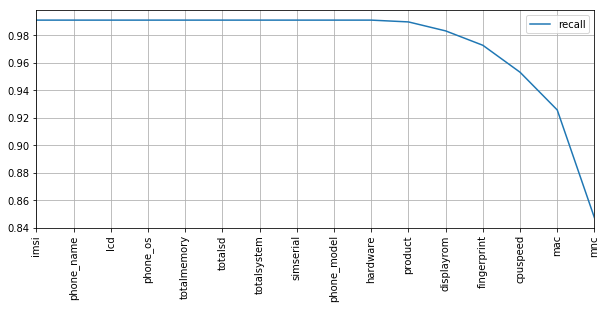

In [31]:
show_ret(ret_list)